In [1]:
import pyanitools as pyt
import pyNeuroChem as pyc
import hdnntools as hdt
import numpy as np

from ase_interface import ANIENS
from ase_interface import ensemblemolecule
from ase.atoms import Atoms

import os

import matplotlib.pyplot as plt

/scratch/Anaconda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


van Der Waals correction will be unavailable. Please install ased3


In [2]:
h5test = '/nh/nest/u/jsmith/Research/tin_research/metal_data/U12.0_test.h5'

ens_path = '/nh/nest/u/jsmith/Research/tin_research/metal_data/models/gutz_lc_models/'

cns = '/train0/rX-2.8R_32-2.0A_a8-8.params'
sae = '/train0/sae.dat'
nnf = '/train'
Nn = 8

In [3]:
model_paths = sorted(os.listdir(ens_path))

comp_all = {}

for model_path in model_paths:
    wkpath = ens_path+model_path
    print(wkpath)
    aens = ensemblemolecule(wkpath + cns,wkpath + sae,wkpath + nnf,Nn)
    
    comp = {'E':[[],[]],
            'F':[[],[]],}
    
    adl = pyt.anidataloader(h5test)
    
    for data in adl:
        print(data['path'])
        X = data['coordinates']
        S = data['species']
        E = data['energies']
        F = data['forces']
        C = data['cell']
        
        for x,e,f,c in zip(X,E,F,C):
            comp['E'][0].append(e)
            comp['F'][0].append(f.flatten())
            
            aens.set_pbc(True,True,True)
            celi = (np.linalg.inv(C)).astype(np.float32)
            aens.set_cell((C).astype(np.float32), celi)

            aens.set_molecule(X=x,S=S)
            ea,fa,es,fs = aens.compute_mean_props()

            comp['E'][1].append(ea)
            comp['F'][1].append(fa.flatten())
            
    comp['E'][0] = np.array(comp['E'][0])
    comp['E'][1] = np.array(comp['E'][1])
    comp['F'][0] = np.concatenate(comp['F'][0])
    comp['F'][1] = np.concatenate(comp['F'][1])
    comp_all[model_path] = comp

/nh/nest/u/jsmith/Research/tin_research/metal_data/models/gutz_lc_models/U12.0_001p
/U12.0/kT0.075
/U12.0/kT0.15
/U12.0/kT0.3
/nh/nest/u/jsmith/Research/tin_research/metal_data/models/gutz_lc_models/U12.0_002p
/U12.0/kT0.075
/U12.0/kT0.15
/U12.0/kT0.3
/nh/nest/u/jsmith/Research/tin_research/metal_data/models/gutz_lc_models/U12.0_005p
/U12.0/kT0.075
/U12.0/kT0.15
/U12.0/kT0.3
/nh/nest/u/jsmith/Research/tin_research/metal_data/models/gutz_lc_models/U12.0_010p
/U12.0/kT0.075
/U12.0/kT0.15
/U12.0/kT0.3
/nh/nest/u/jsmith/Research/tin_research/metal_data/models/gutz_lc_models/U12.0_020p
/U12.0/kT0.075
/U12.0/kT0.15
/U12.0/kT0.3
/nh/nest/u/jsmith/Research/tin_research/metal_data/models/gutz_lc_models/U12.0_035p
/U12.0/kT0.075
/U12.0/kT0.15
/U12.0/kT0.3
/nh/nest/u/jsmith/Research/tin_research/metal_data/models/gutz_lc_models/U12.0_050p
/U12.0/kT0.075
/U12.0/kT0.15
/U12.0/kT0.3
/nh/nest/u/jsmith/Research/tin_research/metal_data/models/gutz_lc_models/U12.0_075p
/U12.0/kT0.075
/U12.0/kT0.15
/U12.

In [6]:
plot_data = {'Emae':[],
             'Fmae':[],
             'perc':[],}

for key in comp_all.keys():
    percent = float(key.split('_')[1][:-1])
    Emae = hdt.calculaterootmeansqrerror(comp_all[key]['E'][0],comp_all[key]['E'][1])
    Fmae = hdt.calculaterootmeansqrerror(comp_all[key]['F'][0],comp_all[key]['F'][1])
    plot_data['perc'].append(percent)
    plot_data['Emae'].append(Emae)
    plot_data['Fmae'].append(Fmae)
    print(percent,Emae,Fmae)

1.0 0.3587117114318182 0.15021463
2.0 0.26349591139570344 0.1451691
5.0 0.24083988978650014 0.1372932
10.0 0.24621375369194187 0.13205692
20.0 0.24897894421432945 0.13071188
35.0 0.24429488595779889 0.12769857
50.0 0.2373311641742515 0.12993558
75.0 0.2324872504929882 0.1282195
100.0 0.24164303761184838 0.12665308


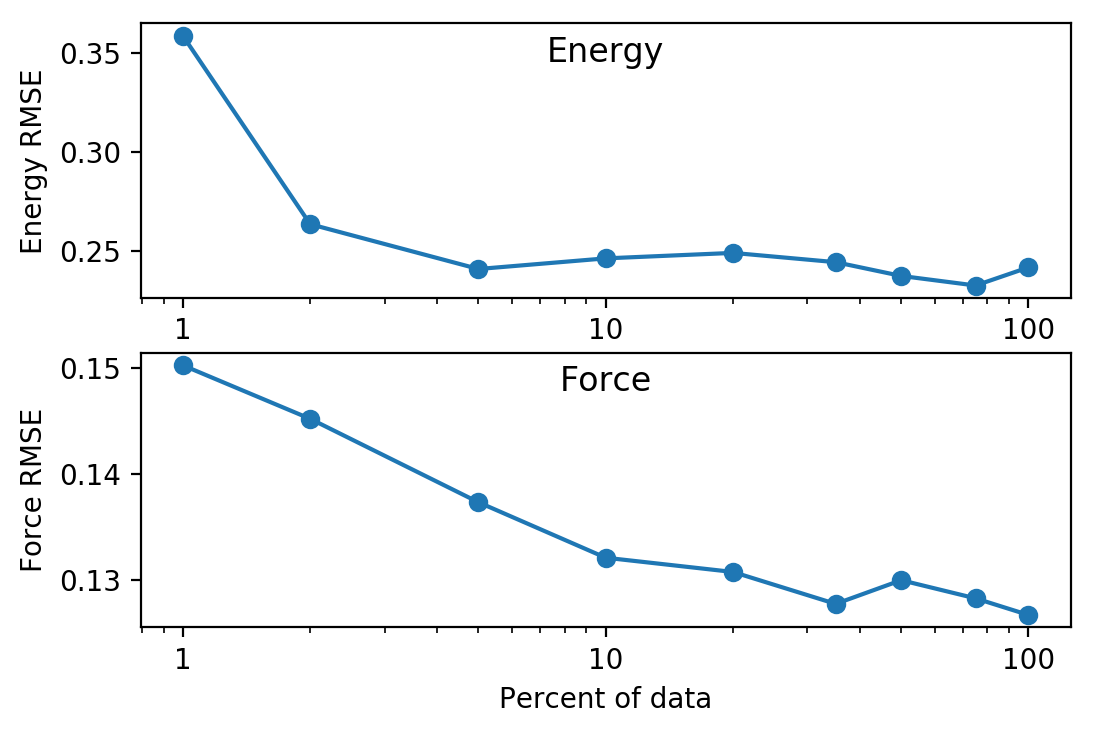

In [85]:
import matplotlib.ticker as ticker

fig, axs = plt.subplots(2, 1, figsize=(6, 4), dpi=200, sharey=False)

axs[0].plot(plot_data['perc'], plot_data['Emae'], '-o')
axs[1].plot(plot_data['perc'], plot_data['Fmae'], '-o')

# remove the x and y ticks
for ax in axs:
    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
    #ax.set_yticks([])

axs[0].set_title("Energy", y=0.8)
axs[1].set_title("Force", y=0.8)

axs[1].set_xlabel("Percent of data")

axs[0].set_ylabel("Energy RMSE")
axs[1].set_ylabel("Force RMSE")
#print(fig.get_yticks())

#axs[0].yaxis.set_ticks_position('none') 
#axs[1].yaxis.set_ticks_position('none') 
#axs[0].yaxis.set_ticks(np.arange(min(plot_data['Emae']), max(plot_data['Emae']), 0.02))
#axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1e'))
#axs[0].xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

plt.show()